In [28]:
import warnings
import pandas as pd
import pydotplus
from ipywidgets import Image
from sklearn.datasets import load_iris
import graphviz
import numbers
import numpy as np

from sklearn.base import ClassifierMixin, MultiOutputMixin, BaseEstimator, is_classifier
from sklearn.externals.six import StringIO
from sklearn.tree._criterion import Criterion
from sklearn.tree._splitter import Splitter
from sklearn.tree._tree import DepthFirstTreeBuilder, DTYPE, DOUBLE
from sklearn.tree._tree import BestFirstTreeBuilder
from sklearn.tree._tree import Tree
from sklearn.tree import _tree, _splitter, _criterion
from sklearn.tree.tree import CRITERIA_CLF, SPARSE_SPLITTERS, DENSE_SPLITTERS, CRITERIA_REG
from sklearn.utils import check_random_state, check_array, compute_sample_weight
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted
from abc import ABCMeta, abstractmethod
from sklearn.datasets import load_iris
from sklearn.tree._tree import DepthFirstTreeBuilder, issparse
from sklearn.tree import _tree, _splitter, _criterion, export_graphviz

class BaseDecisionTree(BaseEstimator, MultiOutputMixin, metaclass=ABCMeta):
  
    @abstractmethod
    def __init__(self,
                 criterion,
                 splitter,
                 max_depth,
                 min_samples_split,
                 min_samples_leaf,
                 min_weight_fraction_leaf,
                 max_features,
                 max_leaf_nodes,
                 random_state,
                 min_impurity_decrease,
                 min_impurity_split,
                 class_weight=None,
                 presort=False):
        self.criterion = criterion
        self.splitter = splitter
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.class_weight = class_weight
        self.presort = presort

    def get_depth(self):
        check_is_fitted(self, 'tree_')
        return self.tree_.max_depth

    def get_n_leaves(self):
        check_is_fitted(self, 'tree_')
        return self.tree_.n_leaves

    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None):

        random_state = check_random_state(self.random_state)
        if check_input:
            X = check_array(X, dtype=DTYPE, accept_sparse="csc")
            y = check_array(y, ensure_2d=False, dtype=None)
            if issparse(X):
                X.sort_indices()

                if X.indices.dtype != np.intc or X.indptr.dtype != np.intc:
                    raise ValueError("No support for np.int64 index based "
                                     "sparse matrices")

        # Determine output settings
        n_samples, self.n_features_ = X.shape
        is_classification = is_classifier(self)

        y = np.atleast_1d(y)
        expanded_class_weight = None

        if y.ndim == 1:
            y = np.reshape(y, (-1, 1))

        self.n_outputs_ = y.shape[1]

        if is_classification:
            check_classification_targets(y)
            y = np.copy(y)

            self.classes_ = []
            self.n_classes_ = []

            if self.class_weight is not None:
                y_original = np.copy(y)

            y_encoded = np.zeros(y.shape, dtype=np.int)
            for k in range(self.n_outputs_):
                classes_k, y_encoded[:, k] = np.unique(y[:, k],
                                                       return_inverse=True)
                self.classes_.append(classes_k)
                self.n_classes_.append(classes_k.shape[0])
            y = y_encoded

            if self.class_weight is not None:
                expanded_class_weight = compute_sample_weight(
                    self.class_weight, y_original)

        else:
            self.classes_ = [None] * self.n_outputs_
            self.n_classes_ = [1] * self.n_outputs_

        self.n_classes_ = np.array(self.n_classes_, dtype=np.intp)

        if getattr(y, "dtype", None) != DOUBLE or not y.flags.contiguous:
            y = np.ascontiguousarray(y, dtype=DOUBLE)

        # Check parameters
        max_depth = ((2 ** 31) - 1 if self.max_depth is None
                     else self.max_depth)
        max_leaf_nodes = (-1 if self.max_leaf_nodes is None
                          else self.max_leaf_nodes)

        if isinstance(self.min_samples_leaf, (numbers.Integral, np.integer)):
            if not 1 <= self.min_samples_leaf:
                raise ValueError("min_samples_leaf must be at least 1 "
                                 "or in (0, 0.5], got %s"
                                 % self.min_samples_leaf)
            min_samples_leaf = self.min_samples_leaf
        else:  # float
            if not 0. < self.min_samples_leaf <= 0.5:
                raise ValueError("min_samples_leaf must be at least 1 "
                                 "or in (0, 0.5], got %s"
                                 % self.min_samples_leaf)
            min_samples_leaf = int(np.ceil(self.min_samples_leaf * n_samples))

        if isinstance(self.min_samples_split, (numbers.Integral, np.integer)):
            if not 2 <= self.min_samples_split:
                raise ValueError("min_samples_split must be an integer "
                                 "greater than 1 or a float in (0.0, 1.0]; "
                                 "got the integer %s"
                                 % self.min_samples_split)
            min_samples_split = self.min_samples_split
        else:  # float
            if not 0. < self.min_samples_split <= 1.:
                raise ValueError("min_samples_split must be an integer "
                                 "greater than 1 or a float in (0.0, 1.0]; "
                                 "got the float %s"
                                 % self.min_samples_split)
            min_samples_split = int(np.ceil(self.min_samples_split * n_samples))
            min_samples_split = max(2, min_samples_split)

        min_samples_split = max(min_samples_split, 2 * min_samples_leaf)

        if isinstance(self.max_features, str):
            if self.max_features == "auto":
                if is_classification:
                    max_features = max(1, int(np.sqrt(self.n_features_)))
                else:
                    max_features = self.n_features_
            elif self.max_features == "sqrt":
                max_features = max(1, int(np.sqrt(self.n_features_)))
            elif self.max_features == "log2":
                max_features = max(1, int(np.log2(self.n_features_)))
            else:
                raise ValueError(
                    'Invalid value for max_features. Allowed string '
                    'values are "auto", "sqrt" or "log2".')
        elif self.max_features is None:
            max_features = self.n_features_
        elif isinstance(self.max_features, (numbers.Integral, np.integer)):
            max_features = self.max_features
        else:  # float
            if self.max_features > 0.0:
                max_features = max(1,
                                   int(self.max_features * self.n_features_))
            else:
                max_features = 0

        self.max_features_ = max_features

        if len(y) != n_samples:
            raise ValueError("Number of labels=%d does not match "
                             "number of samples=%d" % (len(y), n_samples))
        if not 0 <= self.min_weight_fraction_leaf <= 0.5:
            raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
        if max_depth <= 0:
            raise ValueError("max_depth must be greater than zero. ")
        if not (0 < max_features <= self.n_features_):
            raise ValueError("max_features must be in (0, n_features]")
        if not isinstance(max_leaf_nodes, (numbers.Integral, np.integer)):
            raise ValueError("max_leaf_nodes must be integral number but was "
                             "%r" % max_leaf_nodes)
        if -1 < max_leaf_nodes < 2:
            raise ValueError(("max_leaf_nodes {0} must be either None "
                              "or larger than 1").format(max_leaf_nodes))

        if sample_weight is not None:
            if (getattr(sample_weight, "dtype", None) != DOUBLE or
                    not sample_weight.flags.contiguous):
                sample_weight = np.ascontiguousarray(
                    sample_weight, dtype=DOUBLE)
            if len(sample_weight.shape) > 1:
                raise ValueError("Sample weights array has more "
                                 "than one dimension: %d" %
                                 len(sample_weight.shape))
            if len(sample_weight) != n_samples:
                raise ValueError("Number of weights=%d does not match "
                                 "number of samples=%d" %
                                 (len(sample_weight), n_samples))

        if expanded_class_weight is not None:
            if sample_weight is not None:
                sample_weight = sample_weight * expanded_class_weight
            else:
                sample_weight = expanded_class_weight

        # Set min_weight_leaf from min_weight_fraction_leaf
        if sample_weight is None:
            min_weight_leaf = (self.min_weight_fraction_leaf *
                               n_samples)
        else:
            min_weight_leaf = (self.min_weight_fraction_leaf *
                               np.sum(sample_weight))

        if self.min_impurity_split is not None:
            warnings.warn("The min_impurity_split parameter is deprecated. "
                          "Its default value will change from 1e-7 to 0 in "
                          "version 0.23, and it will be removed in 0.25. "
                          "Use the min_impurity_decrease parameter instead.",
                          DeprecationWarning)
            min_impurity_split = self.min_impurity_split
        else:
            min_impurity_split = 1e-7

        if min_impurity_split < 0.:
            raise ValueError("min_impurity_split must be greater than "
                             "or equal to 0")

        if self.min_impurity_decrease < 0.:
            raise ValueError("min_impurity_decrease must be greater than "
                             "or equal to 0")

        allowed_presort = ('auto', True, False)
        if self.presort not in allowed_presort:
            raise ValueError("'presort' should be in {}. Got {!r} instead."
                             .format(allowed_presort, self.presort))

        if self.presort is True and issparse(X):
            raise ValueError("Presorting is not supported for sparse "
                             "matrices.")

        presort = self.presort
        # Allow presort to be 'auto', which means True if the dataset is dense,
        # otherwise it will be False.
        if self.presort == 'auto':
            presort = not issparse(X)

        # If multiple trees are built on the same dataset, we only want to
        # presort once. Splitters now can accept presorted indices if desired,
        # but do not handle any presorting themselves. Ensemble algorithms
        # which desire presorting must do presorting themselves and pass that
        # matrix into each tree.
        if X_idx_sorted is None and presort:
            X_idx_sorted = np.asfortranarray(np.argsort(X, axis=0),
                                             dtype=np.int32)

        if presort and X_idx_sorted.shape != X.shape:
            raise ValueError("The shape of X (X.shape = {}) doesn't match "
                             "the shape of X_idx_sorted (X_idx_sorted"
                             ".shape = {})".format(X.shape,
                                                   X_idx_sorted.shape))

        # Build tree
        criterion = self.criterion
        if not isinstance(criterion, Criterion):
            if is_classification:
                criterion = CRITERIA_CLF[self.criterion](self.n_outputs_,
                                                         self.n_classes_)
            else:
                criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
                                                         n_samples)

        SPLITTERS = SPARSE_SPLITTERS if issparse(X) else DENSE_SPLITTERS

        splitter = self.splitter
        if not isinstance(self.splitter, Splitter):
            splitter = SPLITTERS[self.splitter](criterion,
                                                self.max_features_,
                                                min_samples_leaf,
                                                min_weight_leaf,
                                                random_state,
                                                self.presort)

        self.tree_ = Tree(self.n_features_, self.n_classes_, self.n_outputs_)

        # Use BestFirst if max_leaf_nodes given; use DepthFirst otherwise
        if max_leaf_nodes < 0:
            builder = DepthFirstTreeBuilder(splitter, min_samples_split,
                                            min_samples_leaf,
                                            min_weight_leaf,
                                            max_depth,
                                            self.min_impurity_decrease,
                                            min_impurity_split)
        else:
            builder = BestFirstTreeBuilder(splitter, min_samples_split,
                                           min_samples_leaf,
                                           min_weight_leaf,
                                           max_depth,
                                           max_leaf_nodes,
                                           self.min_impurity_decrease,
                                           min_impurity_split)

        builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)

        if self.n_outputs_ == 1:
            self.n_classes_ = self.n_classes_[0]
            self.classes_ = self.classes_[0]

        return self

    def _validate_X_predict(self, X, check_input):
        if check_input:
            X = check_array(X, dtype=DTYPE, accept_sparse="csr")
            if issparse(X) and (X.indices.dtype != np.intc or
                                X.indptr.dtype != np.intc):
                raise ValueError("No support for np.int64 index based "
                                 "sparse matrices")

        n_features = X.shape[1]
        if self.n_features_ != n_features:
            raise ValueError("Number of features of the model must "
                             "match the input. Model n_features is %s and "
                             "input n_features is %s "
                             % (self.n_features_, n_features))

        return X

    def predict(self, X, check_input=True):
        check_is_fitted(self, 'tree_')
        X = self._validate_X_predict(X, check_input)
        proba = self.tree_.predict(X)
        n_samples = X.shape[0]

        # Classification
        if is_classifier(self):
            if self.n_outputs_ == 1:
                return self.classes_.take(np.argmax(proba, axis=1), axis=0)

            else:
                class_type = self.classes_[0].dtype
                predictions = np.zeros((n_samples, self.n_outputs_),
                                       dtype=class_type)
                for k in range(self.n_outputs_):
                    predictions[:, k] = self.classes_[k].take(
                        np.argmax(proba[:, k], axis=1),
                        axis=0)

                return predictions

        # Regression
        else:
            if self.n_outputs_ == 1:
                return proba[:, 0]

            else:
                return proba[:, :, 0]

    def apply(self, X, check_input=True):
        check_is_fitted(self, 'tree_')
        X = self._validate_X_predict(X, check_input)
        return self.tree_.apply(X)

    def decision_path(self, X, check_input=True):    
        X = self._validate_X_predict(X, check_input)
        return self.tree_.decision_path(X)

    @property
    def feature_importances_(self):
        check_is_fitted(self, 'tree_')

        return self.tree_.compute_feature_importances()


In [29]:
class DTClassifier(BaseDecisionTree, ClassifierMixin):
  
    def __init__(self,
                 criterion="gini",
                 splitter="best",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features=None,
                 random_state=None,
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 class_weight=None,
                 presort=False):
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            max_leaf_nodes=max_leaf_nodes,
            class_weight=class_weight,
            random_state=random_state,
            min_impurity_decrease=min_impurity_decrease,
            min_impurity_split=min_impurity_split,
            presort=presort)

    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None):
      
        super().fit(
            X, y,
            sample_weight=sample_weight,
            check_input=check_input,
            X_idx_sorted=X_idx_sorted)
        return self

    def predict_proba(self, X, check_input=True):
        check_is_fitted(self, 'tree_')
        X = self._validate_X_predict(X, check_input)
        proba = self.tree_.predict(X)

        if self.n_outputs_ == 1:
            proba = proba[:, :self.n_classes_]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0
            proba /= normalizer

            return proba

        else:
            all_proba = []

            for k in range(self.n_outputs_):
                proba_k = proba[:, k, :self.n_classes_[k]]
                normalizer = proba_k.sum(axis=1)[:, np.newaxis]
                normalizer[normalizer == 0.0] = 1.0
                proba_k /= normalizer
                all_proba.append(proba_k)

            return all_proba

    pregnant insulin   bmi age glucose  bp pedigree
1          6       0  33.6  50     148  72    0.627
2          1       0  26.6  31      85  66    0.351
3          8       0  23.3  32     183  64    0.672
4          1      94  28.1  21      89  66    0.167
5          0     168  43.1  33     137  40    2.288
..       ...     ...   ...  ..     ...  ..      ...
764       10     180  32.9  63     101  76    0.171
765        2       0  36.8  27     122  70     0.34
766        5     112  26.2  30     121  72    0.245
767        1       0  30.1  47     126  60    0.349
768        1       0  30.4  23      93  70    0.315

[768 rows x 7 columns]
1      1
2      0
3      1
4      0
5      1
      ..
764    0
765    0
766    0
767    1
768    0
Name: label, Length: 768, dtype: object


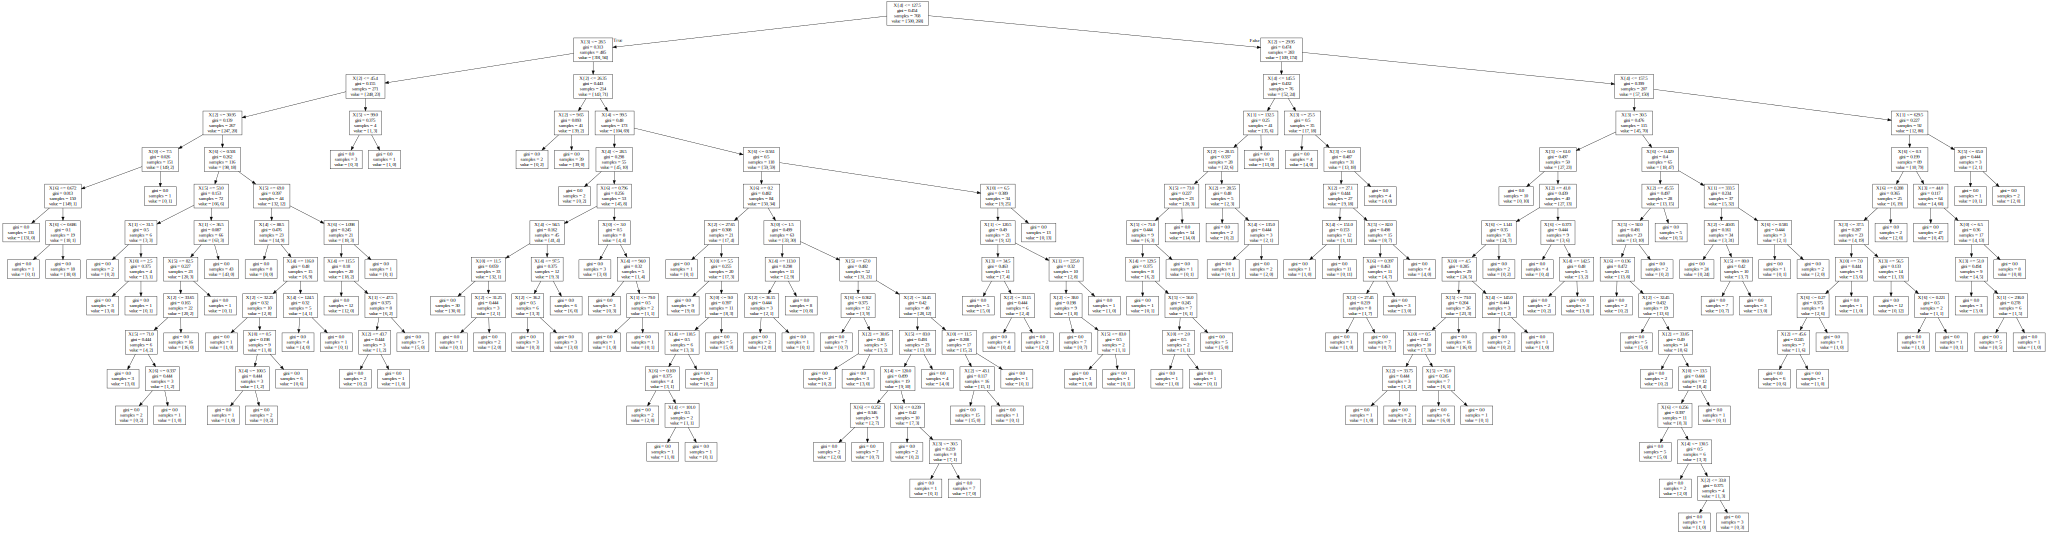

In [30]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# load dataset
data = pd.read_csv("diabetes.csv", header=None, names=col_names)
data.head()
data = data.iloc[1:]

# split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age', 'glucose', 'bp', 'pedigree']
X = data[feature_cols]  # Features
y = data.label  # Target variable

#  gini criteria is used by default
clf = DTClassifier()
clf = clf.fit(X, y)

print(X)
print(y)

dot_data = export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph